In [1]:
source("/secure/projects/HTAPP_MBC/src/init_phase2.R")

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3
Loading combined annotation: annot


In [2]:
library(pheatmap)

In [3]:
setwd(paste0(spatialDir,"/01_typing/combined_all/"))

In [4]:
mal_obs=fread(paste0("merfish_mal_obs.tsv"))
obs=fread(paste0("merfish_obs.tsv"))

In [5]:
#set OT as cell_type column
setnames(obs,old = "OT",new = "cell_type")

In [6]:
unique(obs$cell_type)

[1] "Smooth muscle_vascular" "NK"                     "Endothelial_angiogenic"
 [4] "MBC_neuronal"           "Fibroblast"             "Monocyte"              
 [7] "Macrophage"             "Endothelial_vascular"   "MBC"                   
[10] "Hepatocyte"             "T"                      "Mast"                  
[13] "Endothelial"            "MBC_stem-like"          "B"                     
[16] "B_plasma"

### Calculate cell type fractions per bin

In [7]:
ct_counts=obs[,.(ct_count=.N),by=c("sample","replicate","bin_100","cell_type")]

In [8]:
pre_expand=unique(ct_counts[,c("sample","bin_100","cell_type","replicate")])
expand=pre_expand[,expand.grid(bin_100=unique(bin_100),cell_type=unique(cell_type)),by=c("sample","replicate")]

In [9]:
ct_counts=merge(ct_counts,expand,by=c("sample","bin_100","cell_type","replicate"),all = TRUE)

In [10]:
ct_counts[,ct_count:=ifelse(is.na(ct_count),0,ct_count),]

In [11]:
#simple normalization
ct_counts[,ct_frac:=ct_count/sum(ct_count),by=c("sample","replicate","bin_100")]

In [12]:
#center log ratio
ct_counts[,clr:=log(ct_count+1)-mean(log(ct_count+1)),by=c("sample","replicate","bin_100")]

In [13]:
head(ct_counts)

sample,bin_100,cell_type,replicate,ct_count,ct_frac,clr
<chr>,<int>,<fct>,<int>,<dbl>,<dbl>,<dbl>
HTAPP-313-SMP-932,3,NK,1,0,0.0000000,-0.1791759
HTAPP-313-SMP-932,3,Fibroblast,1,1,0.3333333,0.5139712
HTAPP-313-SMP-932,3,Monocyte,1,0,0.0000000,-0.1791759
HTAPP-313-SMP-932,3,Macrophage,1,0,0.0000000,-0.1791759
HTAPP-313-SMP-932,3,MBC,1,2,0.6666667,0.9194363
HTAPP-313-SMP-932,3,Hepatocyte,1,0,0.0000000,-0.1791759


### Calculate EMT category (high/low) per bin

In [14]:
mean_EMT=mal_obs[,.(mean_EMT=mean(EMT_fresh)),by=c("sample","replicate","bin_100")]

In [15]:
mean_EMT[,EMT_cat:=ifelse(mean_EMT>median(mean_EMT),"high","low"),by=c("sample","replicate")]

In [16]:
mean_EMT[,N_bins:=.N,by=c("sample","replicate","EMT_cat")]

In [17]:
head(mean_EMT)

sample,replicate,bin_100,mean_EMT,EMT_cat,N_bins
<chr>,<int>,<int>,<dbl>,<chr>,<int>
HTAPP-944-SMP-7479,1,862,-0.06563746,low,173
HTAPP-944-SMP-7479,1,1073,-0.08384991,low,173
HTAPP-944-SMP-7479,1,1359,-0.14953849,low,173
HTAPP-944-SMP-7479,1,1655,-0.07976826,low,173
HTAPP-944-SMP-7479,1,481,-0.07386284,low,173
HTAPP-944-SMP-7479,1,896,-0.03460288,high,173


### Combine ct counts and EMT category

In [72]:
ct_EMT=merge(ct_counts,mean_EMT,by=c("sample","replicate","bin_100"))

In [73]:
head(ct_EMT)

sample,replicate,bin_100,cell_type,ct_count,ct_frac,clr,mean_EMT,EMT_cat,N_bins
<chr>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HTAPP-313-SMP-932,1,3,NK,0,0.0000000,-0.1791759,-0.147772,high,289
HTAPP-313-SMP-932,1,3,Fibroblast,1,0.3333333,0.5139712,-0.147772,high,289
HTAPP-313-SMP-932,1,3,Monocyte,0,0.0000000,-0.1791759,-0.147772,high,289
HTAPP-313-SMP-932,1,3,Macrophage,0,0.0000000,-0.1791759,-0.147772,high,289
HTAPP-313-SMP-932,1,3,MBC,2,0.6666667,0.9194363,-0.147772,high,289
HTAPP-313-SMP-932,1,3,Hepatocyte,0,0.0000000,-0.1791759,-0.147772,high,289


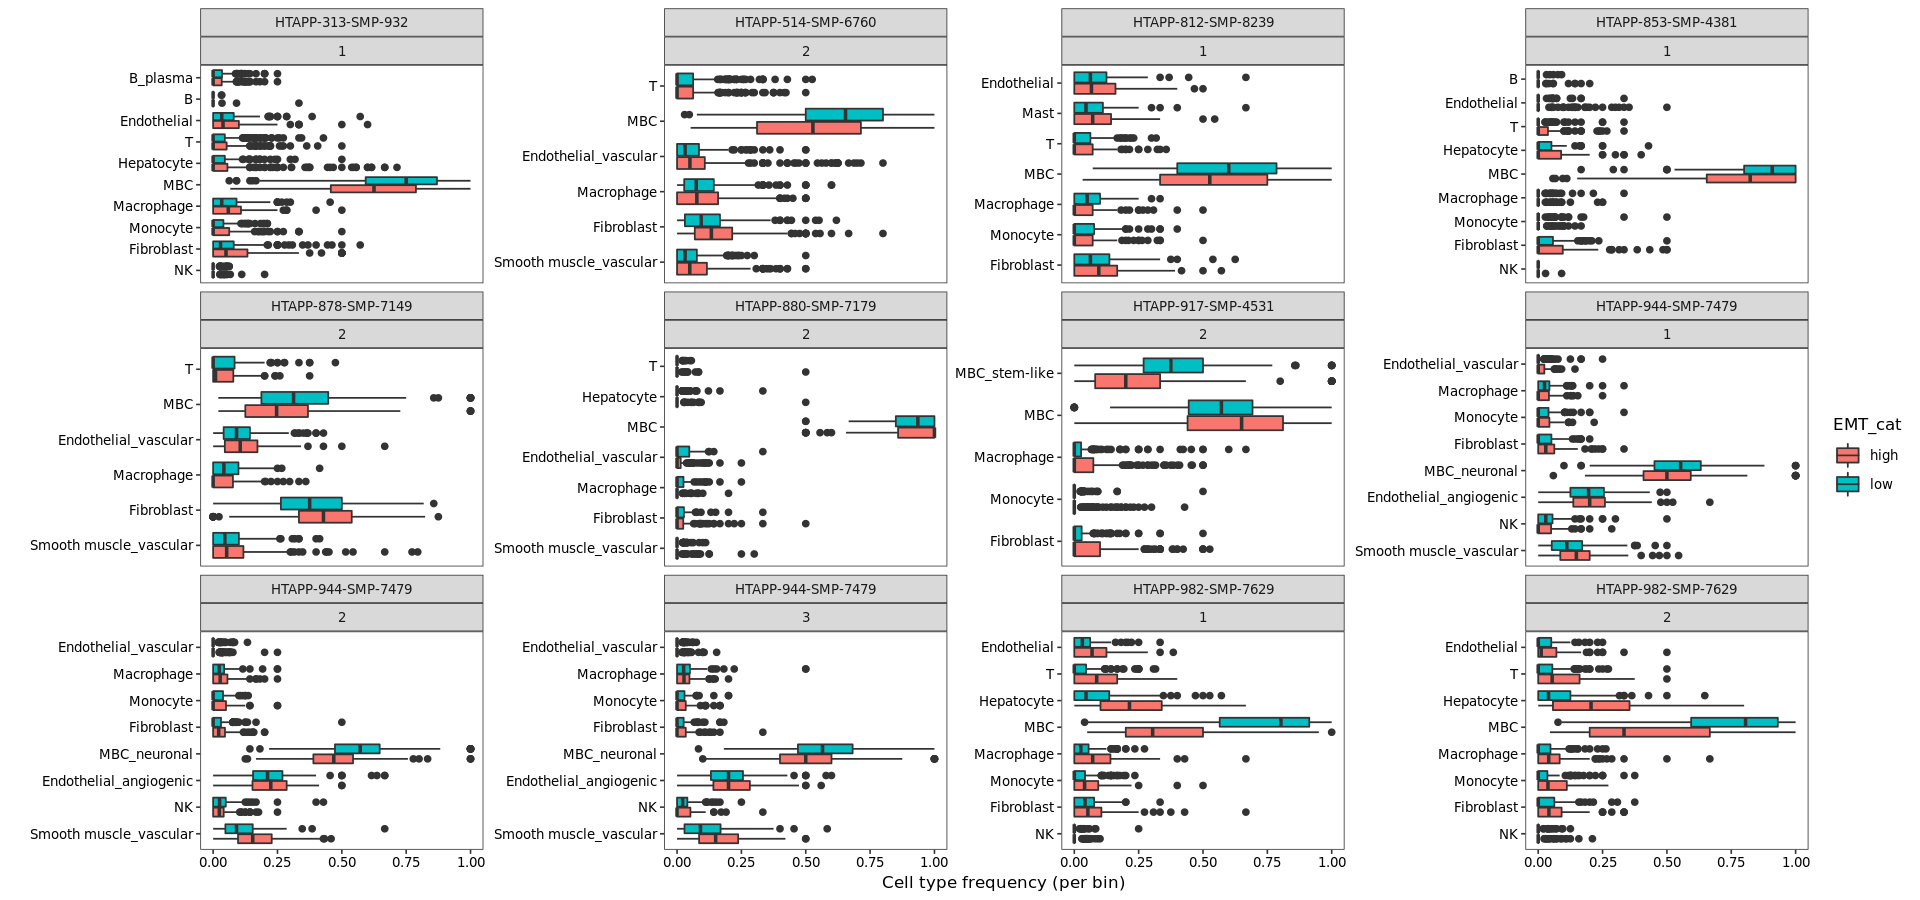

In [74]:
options(repr.plot.width = 16, repr.plot.height =7.5)
ggplot(ct_EMT,aes(x=cell_type,y=ct_frac,fill=EMT_cat))+geom_boxplot()+facet_wrap(~sample+replicate,scale="free_y")+coord_flip()+xlab("")+ylab("Cell type frequency (per bin)")

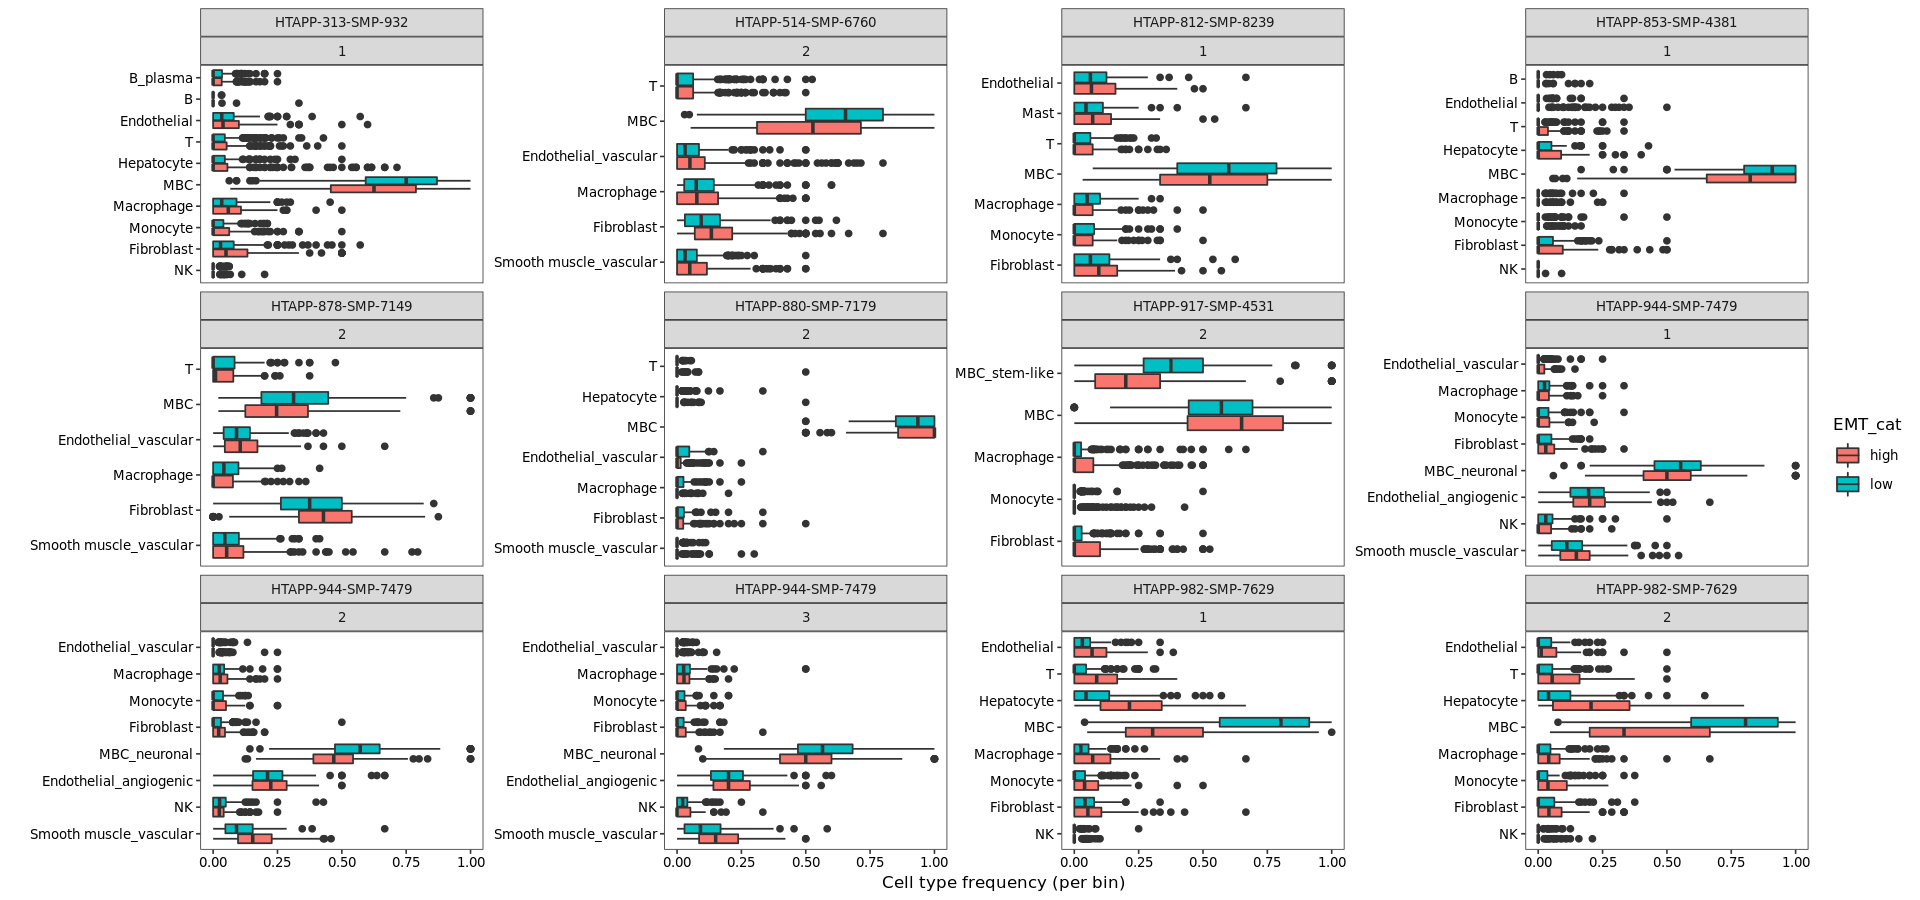

In [62]:
options(repr.plot.width = 16, repr.plot.height =7.5)
ggplot(ct_EMT,aes(x=cell_type,y=ct_frac,fill=EMT_cat))+geom_boxplot()+facet_wrap(~sample+replicate,scale="free_y")+coord_flip()+xlab("")+ylab("Cell type frequency (per bin)")

In [75]:
calc_wilcox=function(dt){
    res=wilcox.test(dt[EMT_cat=="high"]$clr,dt[EMT_cat=="low"]$clr)
    return(res$p.value)
}

In [76]:
#calculate stats on clr
ct_EMT[,p.value:=calc_wilcox(.SD),by=c("sample","replicate","cell_type")]

In [77]:
ct_EMT_ratios=ct_EMT[,.(log2FC=log2(mean(ct_frac[EMT_cat=="high"])/mean(ct_frac[EMT_cat=="low"])),N_bins=mean(N_bins),p.value=unique(p.value)),by=c("sample","replicate","cell_type")]

In [78]:
ct_EMT_ratios[,p.adj:=p.adjust(p = p.value,method = "fdr"),by=c("sample","replicate")]

In [79]:
ct_EMT_ratios[,signif:=ifelse(p.adj<0.05,"p<0.05","p>=0.05"),]

In [80]:
ct_EMT_ratios[,sample_repl:=paste0(sample,"_",replicate),]

In [81]:
#set order
ct_EMT_ratios[,sample_repl:=factor(sample_repl,levels=rev(c('HTAPP-812-SMP-8239_1','HTAPP-514-SMP-6760_2','HTAPP-878-SMP-7149_2',
                                                            'HTAPP-880-SMP-7179_2','HTAPP-313-SMP-932_1','HTAPP-853-SMP-4381_1',
                                                            'HTAPP-982-SMP-7629_1','HTAPP-982-SMP-7629_2','HTAPP-917-SMP-4531_2',
                                                            'HTAPP-944-SMP-7479_1','HTAPP-944-SMP-7479_2','HTAPP-944-SMP-7479_3'))),]
ct_EMT_ratios[,cell_type:=factor(cell_type,levels=c("MBC","MBC_stem-like","MBC_neuronal","Endothelial","Endothelial_angiogenic",
                                                    "Endothelial_vascular","Fibroblast","Smooth muscle_vascular","Hepatocyte",
                                                    "Macrophage","Monocyte","Mast","T","NK","B","B_plasma")),]


In [82]:
head(ct_EMT_ratios)

sample,replicate,cell_type,log2FC,N_bins,p.value,p.adj,signif,sample_repl
<chr>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
HTAPP-313-SMP-932,1,NK,0.3049866,289,8.847288e-01,8.847288e-01,p>=0.05,HTAPP-313-SMP-932_1
HTAPP-313-SMP-932,1,Fibroblast,0.5061711,289,4.629660e-03,2.314830e-02,p<0.05,HTAPP-313-SMP-932_1
HTAPP-313-SMP-932,1,Monocyte,0.7086035,289,2.708715e-02,9.029050e-02,p>=0.05,HTAPP-313-SMP-932_1
HTAPP-313-SMP-932,1,Macrophage,0.2954807,289,1.460176e-01,3.650440e-01,p>=0.05,HTAPP-313-SMP-932_1
HTAPP-313-SMP-932,1,MBC,-0.2269487,289,7.581529e-09,7.581529e-08,p<0.05,HTAPP-313-SMP-932_1
HTAPP-313-SMP-932,1,Hepatocyte,1.0612657,289,8.309543e-01,8.847288e-01,p>=0.05,HTAPP-313-SMP-932_1


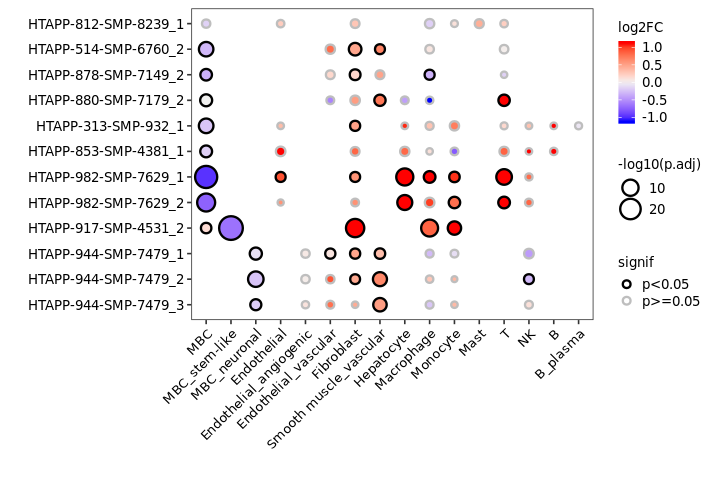

In [83]:
options(repr.plot.width = 6, repr.plot.height =4)
min_lfc=min(ct_EMT_ratios$log2FC)

ggplot(ct_EMT_ratios,aes(y=sample_repl,x=cell_type,col=signif,fill=log2FC,size=-log10(p.adj)))+
geom_point(shape=21,stroke=1)+rotate_labels(angle = 45)+
scale_fill_gradient2(low="blue",mid="grey95",high="red",midpoint = 0,limits = c(min_lfc,-min_lfc),na.value="red")+
scale_color_manual(values = c("p>=0.05"="grey","p<0.05"="black"))+ylab("")+xlab("")+
theme(legend.key.size = unit(0.35, 'cm'),legend.title = element_text(size=8))

### As function to run across multiple cell types/methods

In [23]:
get_ct_emt_association=function(mal_obs,obs,mode){
    #load data
    mal_obs=fread(mal_obs)
    obs=fread(obs)
    if (mode!="merfish_clean"){
    #set OT as cell_type column
    setnames(obs,old = "OT",new = "cell_type")}

    
    ### Calculate cell type fractions per bin

    #expand to include 0 counts in bins
    ct_counts=obs[,.(ct_count=.N),by=c("sample","replicate","bin_100","cell_type")]
    pre_expand=unique(ct_counts[,c("sample","bin_100","cell_type","replicate")])
    expand=pre_expand[,expand.grid(bin_100=unique(bin_100),cell_type=unique(cell_type)),by=c("sample","replicate")]
    ct_counts=merge(ct_counts,expand,by=c("sample","bin_100","cell_type","replicate"),all = TRUE)

    ct_counts[,ct_count:=ifelse(is.na(ct_count),0,ct_count),]

    #simple normalization
    ct_counts[,ct_frac:=ct_count/sum(ct_count),by=c("sample","replicate","bin_100")]
    #center log ratio
    ct_counts[,clr:=log(ct_count+1)-mean(log(ct_count+1)),by=c("sample","replicate","bin_100")]


    ### Calculate EMT category (high/low) per bin
    mean_EMT=mal_obs[,.(mean_EMT=mean(EMT_fresh)),by=c("sample","replicate","bin_100")]
    mean_EMT[,EMT_cat:=ifelse(mean_EMT>median(mean_EMT),"high","low"),by=c("sample","replicate")]
    mean_EMT[,N_bins:=.N,by=c("sample","replicate","EMT_cat")]

    ### Combine ct counts and EMT category
    ct_EMT=merge(ct_counts,mean_EMT,by=c("sample","replicate","bin_100"))

    #plot ct fraction boxplots
    pl1=ggplot(ct_EMT,aes(x=cell_type,y=ct_frac,fill=EMT_cat))+geom_boxplot()+facet_wrap(~sample+replicate,scale="free_y")+coord_flip()+xlab("")+ylab("Cell type frequency (per bin)")

    calc_wilcox=function(dt){
        res=wilcox.test(dt[EMT_cat=="high"]$clr,dt[EMT_cat=="low"]$clr)
        return(res$p.value)
    }

    #calculate stats on clr
    ct_EMT[,p.value:=calc_wilcox(.SD),by=c("sample","replicate","cell_type")]

    #calculate ct ratios (on simple ct fractions)
    ct_EMT_ratios=ct_EMT[,.(log2FC=log2(mean(ct_frac[EMT_cat=="high"])/mean(ct_frac[EMT_cat=="low"])),N_bins=mean(N_bins),p.value=unique(p.value)),by=c("sample","replicate","cell_type")]

    ct_EMT_ratios[,p.adj:=p.adjust(p = p.value,method = "fdr"),by=c("sample","replicate")]
    ct_EMT_ratios[,signif:=ifelse(p.adj<0.05,"p<0.05","p>=0.05"),]
    ct_EMT_ratios[,sample_repl:=paste0(sample,"_",replicate),]

    #set order
    ct_EMT_ratios[,sample_repl:=factor(sample_repl,levels=rev(c('HTAPP-812-SMP-8239_1','HTAPP-812-SMP-8239_2','HTAPP-514-SMP-6760_1',
                                                                'HTAPP-514-SMP-6760_2','HTAPP-878-SMP-7149_1','HTAPP-878-SMP-7149_2',
                                                            'HTAPP-880-SMP-7179_1','HTAPP-880-SMP-7179_2','HTAPP-313-SMP-932_1',
                                                                'HTAPP-313-SMP-932_2','HTAPP-853-SMP-4381_1','HTAPP-853-SMP-4381_2',
                                                            'HTAPP-982-SMP-7629_1','HTAPP-982-SMP-7629_2','HTAPP-917-SMP-4531_1',
                                                                'HTAPP-917-SMP-4531_2','HTAPP-944-SMP-7479_1','HTAPP-944-SMP-7479_2',
                                                                'HTAPP-944-SMP-7479_3'))),]
    ct_EMT_ratios[,cell_type:=factor(cell_type,levels=c("MBC","MBC_stem-like","MBC_neuronal","Endothelial","Endothelial_angiogenic",
                                                    "Endothelial_vascular","Endothelial_sinusoidal","Fibroblast","Smooth muscle_vascular",
                                                        "Stellate","Hepatocyte",
                                                    "Macrophage","Monocyte","Mast","T","NK","B","B_plasma","B_regulatory")),]



    min_lfc=min(ct_EMT_ratios$log2FC[ct_EMT_ratios$log2FC!=-Inf])
    print(min_lfc)
    ct_EMT_ratios[,log2FC:=ifelse(log2FC==Inf,max(ct_EMT_ratios$log2FC[ct_EMT_ratios$log2FC!=Inf]),
                                  ifelse(log2FC==-Inf,min(ct_EMT_ratios$log2FC[ct_EMT_ratios$log2FC!=-Inf]),log2FC)),]

    ct_EMT_ratios[,method:=mode,]
    
    pl2=ggplot(ct_EMT_ratios,aes(y=sample_repl,x=cell_type,col=signif,fill=log2FC,size=-log10(p.adj)))+
    geom_point(shape=21,stroke=1)+rotate_labels(angle = 45)+
#    scale_fill_gradient2(low="blue",mid="grey95",high="red",midpoint = 0,limits = c(min_lfc,-min_lfc),na.value="red")+
    scale_fill_gradient2(low="blue",mid="grey95",high="red",midpoint = 0,limits = c(-1,1),oob = scales::squish)+
    scale_color_manual(values = c("p>=0.05"="grey","p<0.05"="black"))+ylab("")+xlab("")+
    scale_size_continuous(limits=c(0,45))+
    theme(legend.key.size = unit(0.35, 'cm'),legend.title = element_text(size=8))
    
    pdf(paste0("EMT_ct_fractions_bubble_",mode[1],".pdf"),height=4,width=6)
    print(pl2)
    dev.off()
    return(list(pl1,pl2,ct_EMT_ratios))
}

In [24]:
all_stats=data.table()

In [25]:
merfish_man_pl=get_ct_emt_association("../combined_merfish/merfish_mal_obs.tsv","../combined_merfish/merfish_obs.tsv",mode = "merfish_clean")

[1] -3.01473


In [26]:
all_stats=rbindlist(list(all_stats,merfish_man_pl[[3]]))

[[1]]


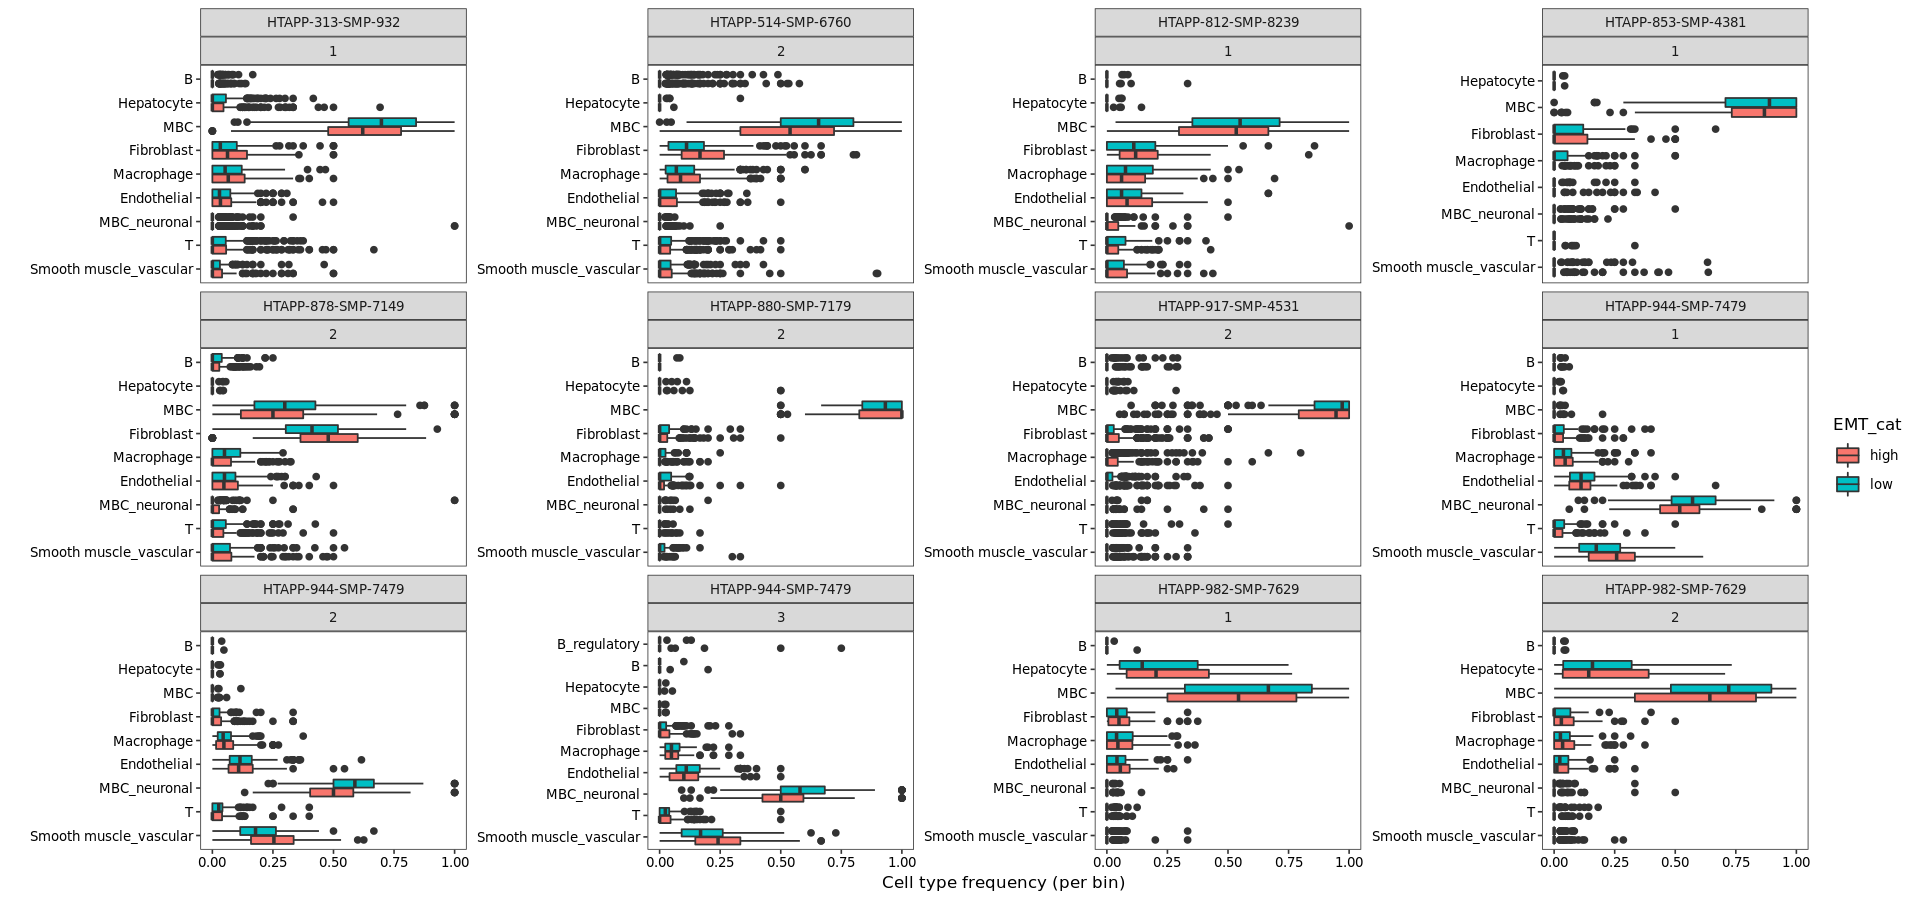

In [28]:
options(repr.plot.width = 16, repr.plot.height =7.5)
merfish_man_pl[1]

[[1]]


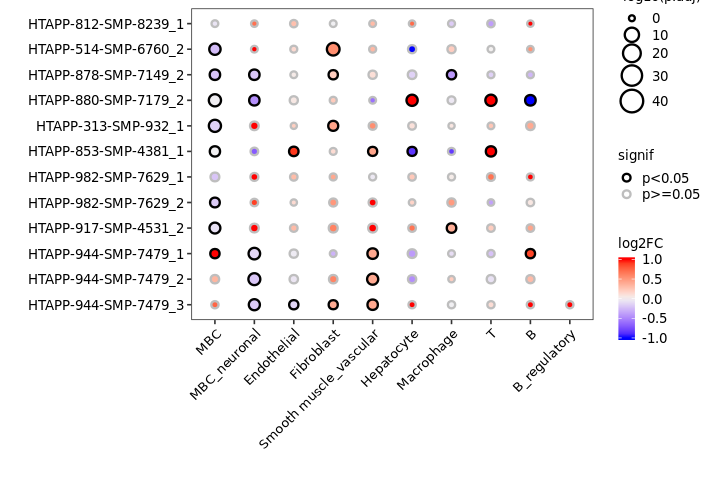

In [30]:
options(repr.plot.width = 6, repr.plot.height =4)
merfish_man_pl[2]

In [31]:
merfish_pl=get_ct_emt_association("merfish_mal_obs.tsv","merfish_obs.tsv",mode="merfish")

[1] -1.120273


In [32]:
all_stats=rbindlist(list(all_stats,merfish_pl[[3]]))

[[1]]


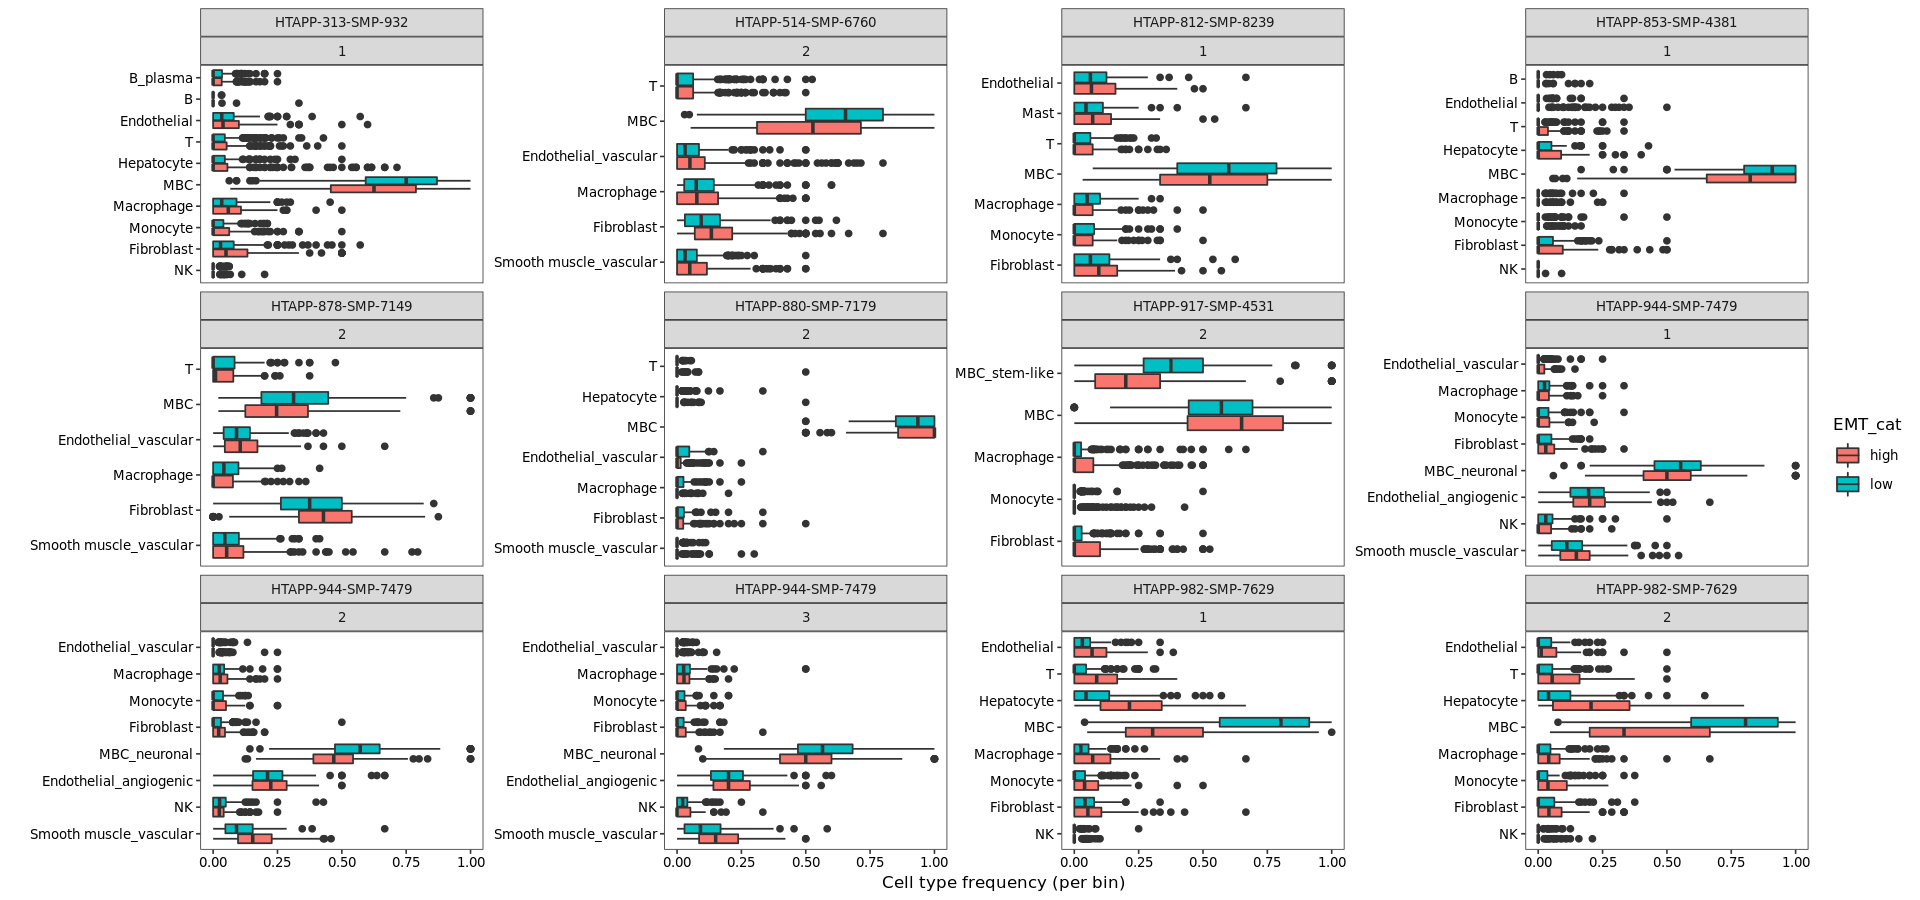

In [33]:
options(repr.plot.width = 16, repr.plot.height =7.5)
merfish_pl[1]

[[1]]


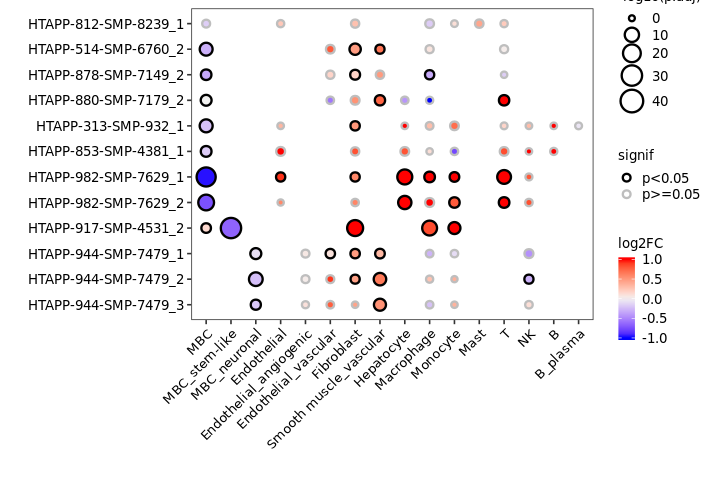

In [34]:
options(repr.plot.width = 6, repr.plot.height =4)
merfish_pl[2]

In [35]:
merfish_bin_pl=get_ct_emt_association("merfish_bin_mal_obs.tsv","merfish_bin_obs.tsv",mode="merfish_bin")

[1] -0.9220721


In [36]:
all_stats=rbindlist(list(all_stats,merfish_bin_pl[[3]]))

[[1]]


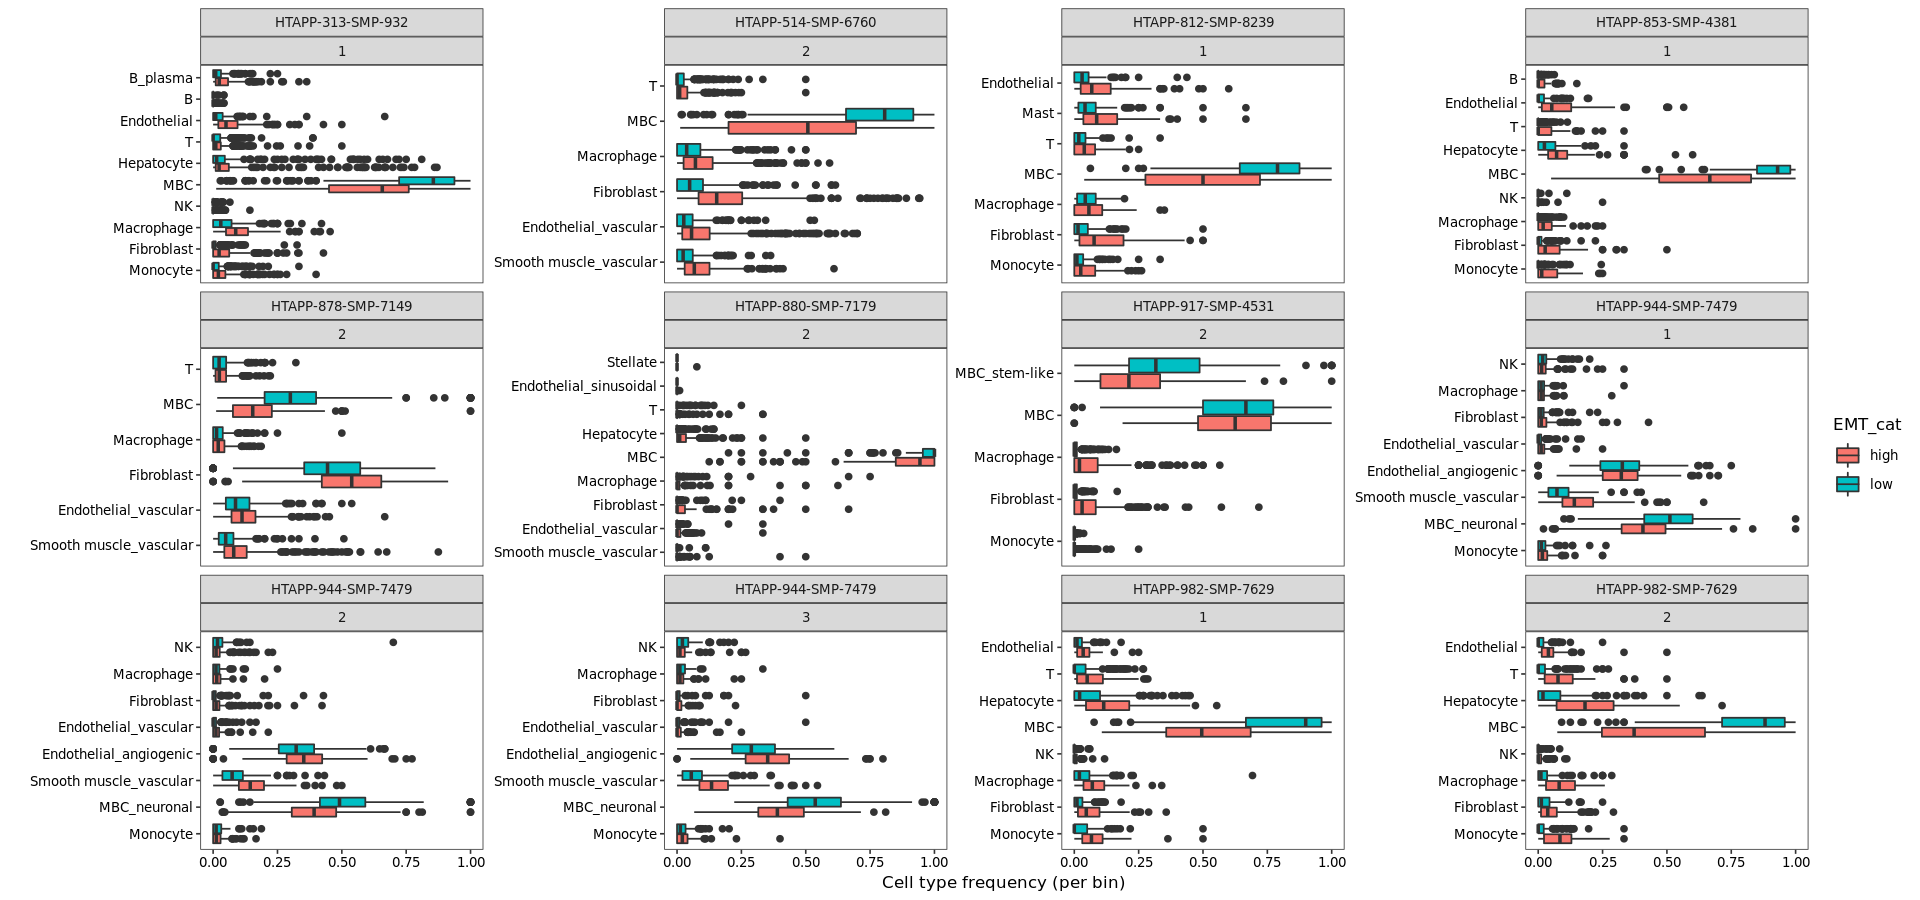

In [37]:
options(repr.plot.width = 16, repr.plot.height =7.5)
merfish_bin_pl[1]

[[1]]


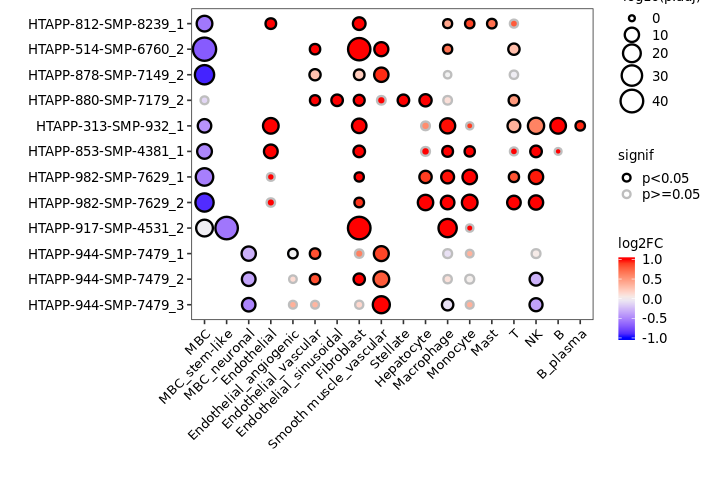

In [38]:
options(repr.plot.width = 6, repr.plot.height =4)
merfish_bin_pl[2]

In [39]:
slide_seq_pl=get_ct_emt_association("slide_seq_mal_obs.tsv","slide_seq_obs.tsv",mode="slide_seq")

[1] -1.134665


In [40]:
all_stats=rbindlist(list(all_stats,slide_seq_pl[[3]]))

[[1]]


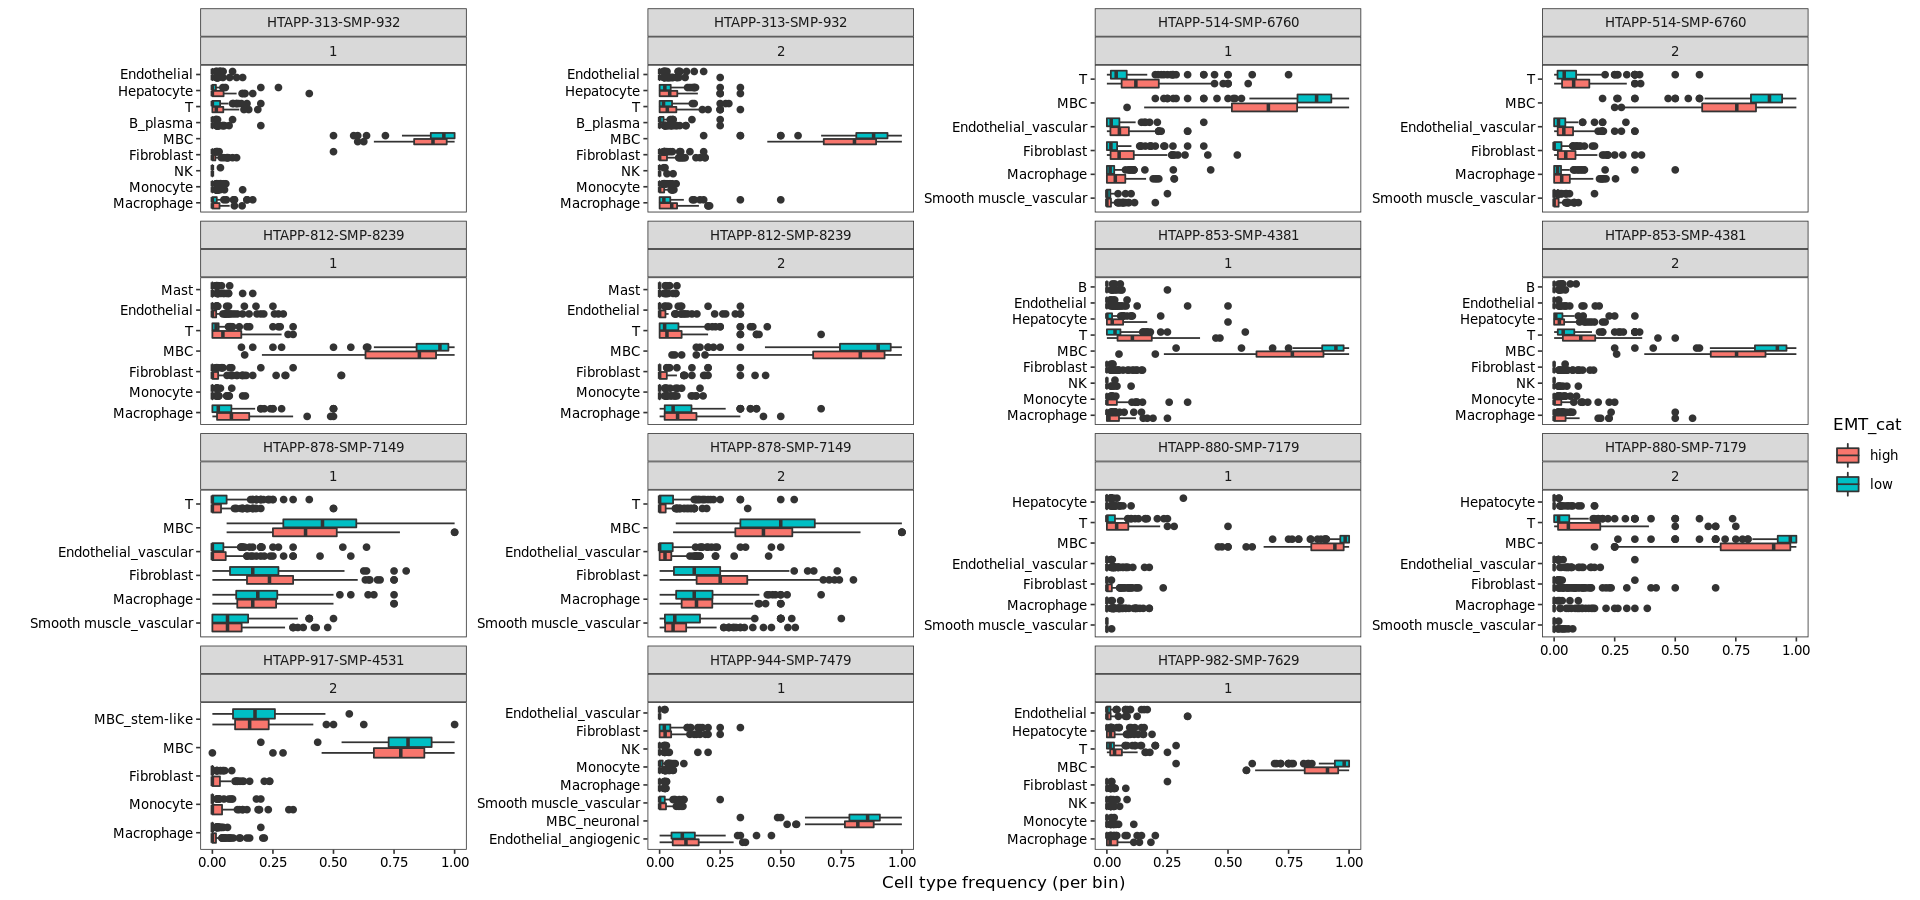

In [41]:
options(repr.plot.width = 16, repr.plot.height =7.5)
slide_seq_pl[1]

[[1]]


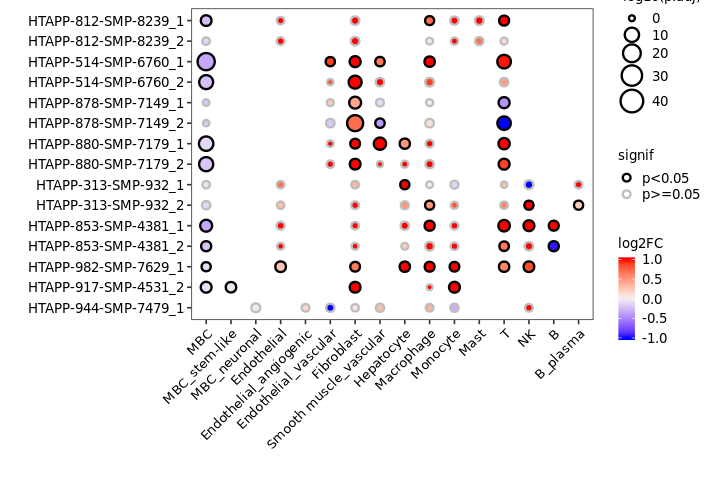

In [42]:
options(repr.plot.width = 6, repr.plot.height =4)
slide_seq_pl[2]

In [43]:
exseq_pl=get_ct_emt_association("exseq_mal_obs.tsv","exseq_obs.tsv",mode="exseq")

Warning message in wilcox.test.default(dt[EMT_cat == "high"]$clr, dt[EMT_cat == :
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(dt[EMT_cat == "high"]$clr, dt[EMT_cat == :
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(dt[EMT_cat == "high"]$clr, dt[EMT_cat == :
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(dt[EMT_cat == "high"]$clr, dt[EMT_cat == :
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(dt[EMT_cat == "high"]$clr, dt[EMT_cat == :
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(dt[EMT_cat == "high"]$clr, dt[EMT_cat == :
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(dt[EMT_cat == "high"]$clr, dt[EMT_cat == :
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(dt[EMT_cat == "high"]$clr, dt[EMT_cat == :
"cannot compute exact p-value with ties"Warning message in wilco

[1] -2.233156


In [44]:
all_stats=rbindlist(list(all_stats,exseq_pl[[3]]))

[[1]]


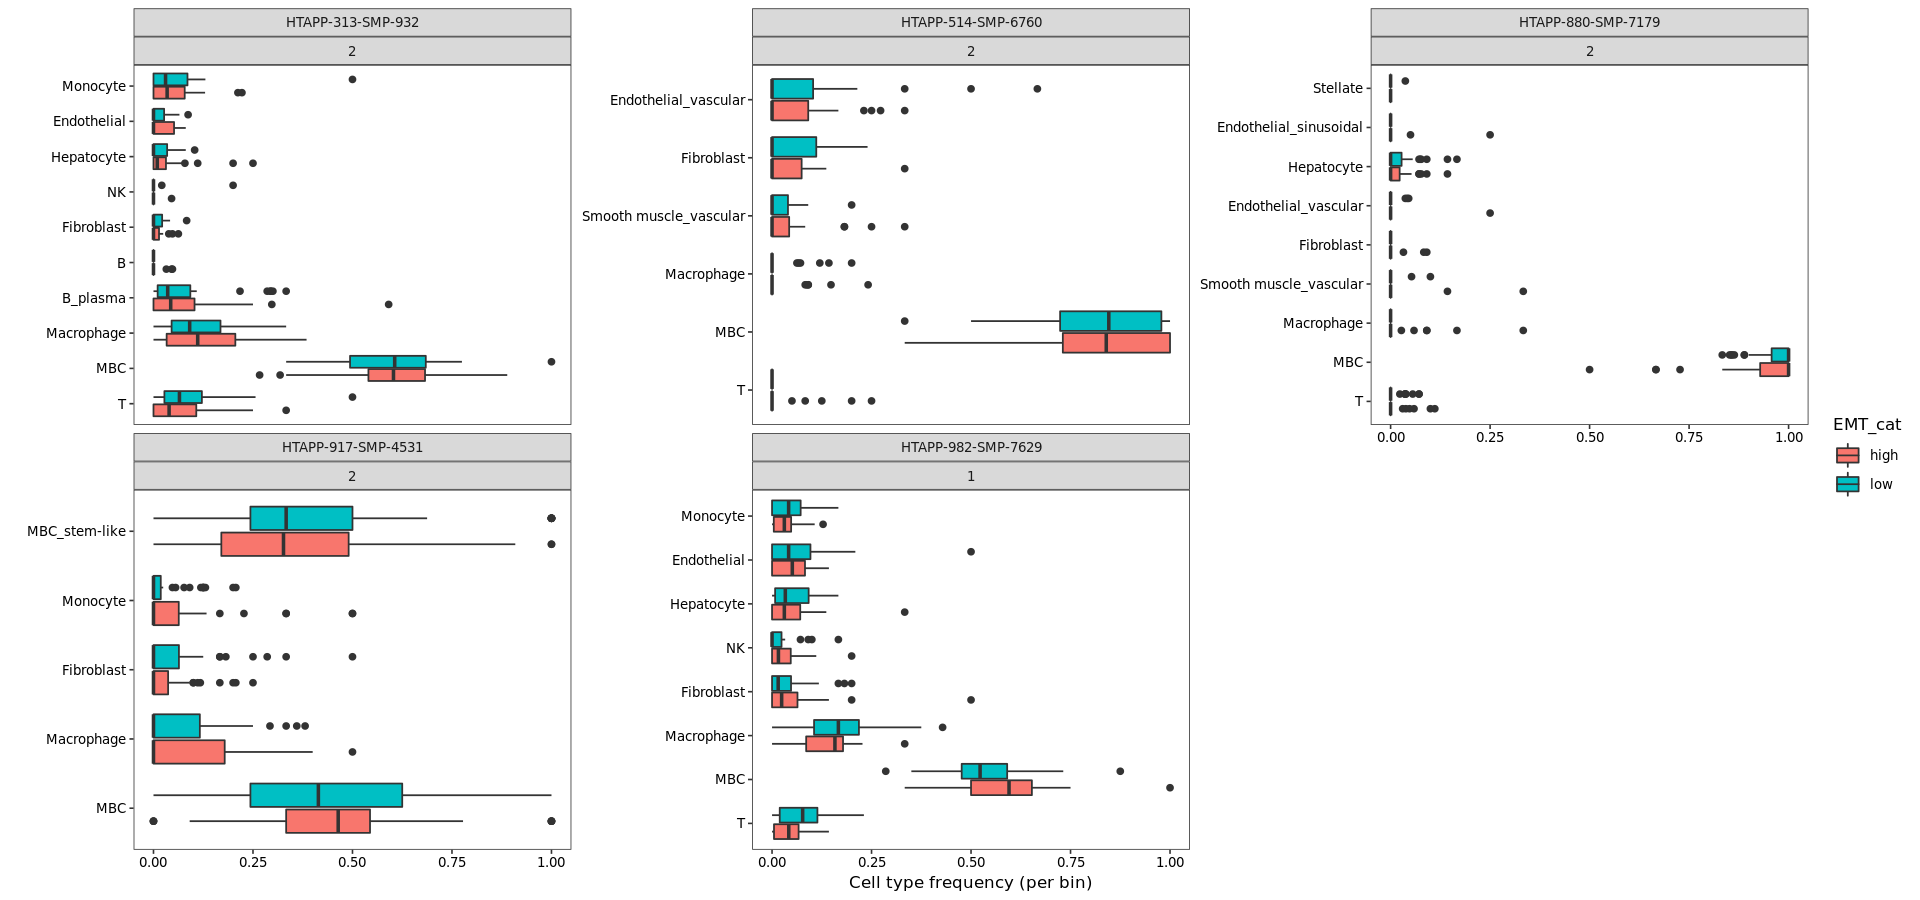

In [45]:
options(repr.plot.width = 16, repr.plot.height =7.5)
exseq_pl[1]

[[1]]


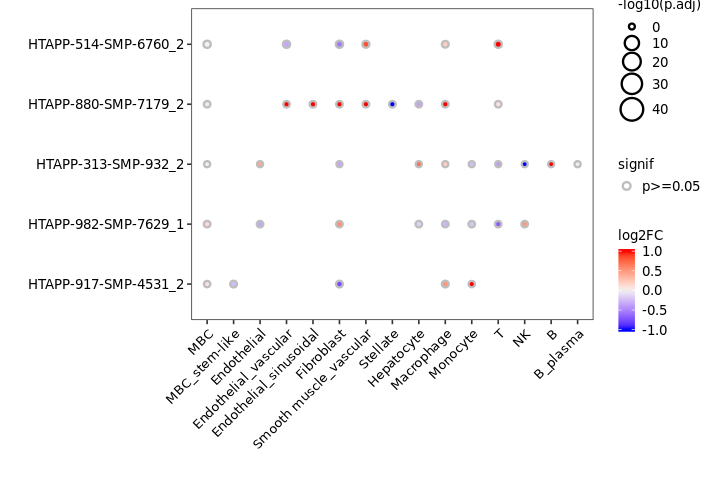

In [46]:
options(repr.plot.width = 6, repr.plot.height =4)
exseq_pl[2]

In [47]:
exseq_bin_pl=get_ct_emt_association("exseq_bin_mal_obs.tsv","exseq_bin_obs.tsv",mode="exseq_bin")

Warning message in wilcox.test.default(dt[EMT_cat == "high"]$clr, dt[EMT_cat == :
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(dt[EMT_cat == "high"]$clr, dt[EMT_cat == :
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(dt[EMT_cat == "high"]$clr, dt[EMT_cat == :
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(dt[EMT_cat == "high"]$clr, dt[EMT_cat == :
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(dt[EMT_cat == "high"]$clr, dt[EMT_cat == :
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(dt[EMT_cat == "high"]$clr, dt[EMT_cat == :
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(dt[EMT_cat == "high"]$clr, dt[EMT_cat == :
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(dt[EMT_cat == "high"]$clr, dt[EMT_cat == :
"cannot compute exact p-value with ties"Warning message in wilco

[1] -2.307921


In [48]:
all_stats=rbindlist(list(all_stats,exseq_bin_pl[[3]]))

[[1]]


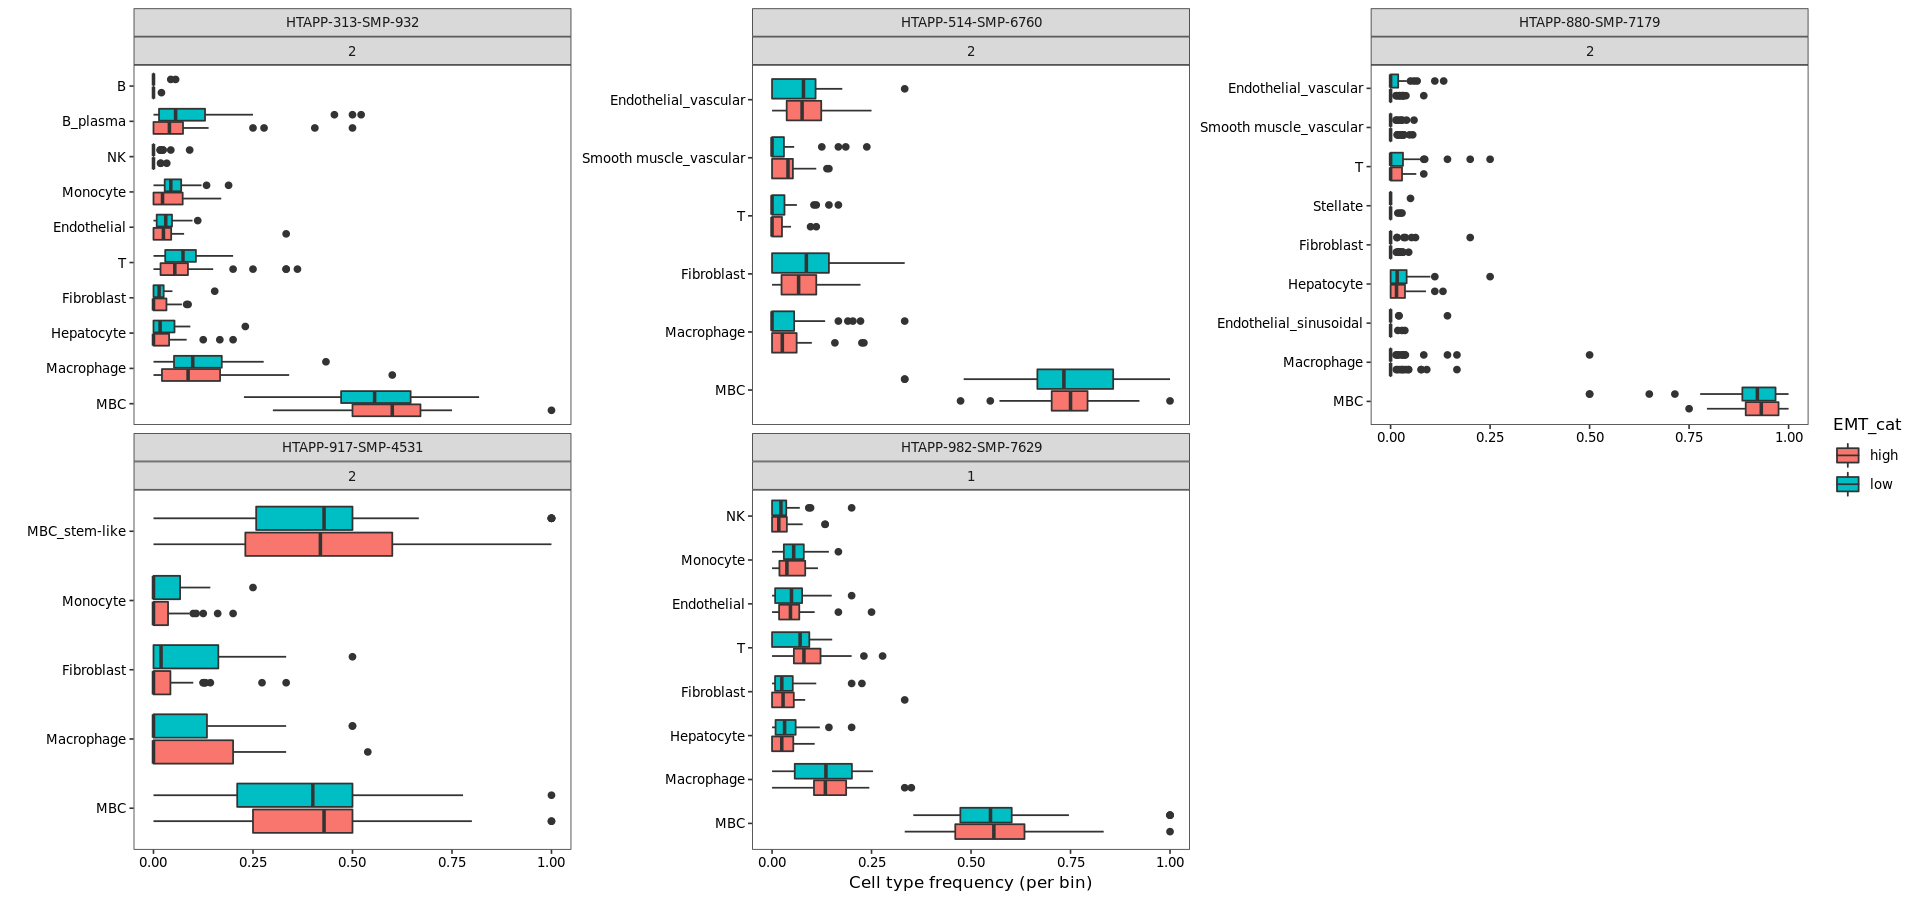

In [49]:
options(repr.plot.width = 16, repr.plot.height =7.5)
exseq_bin_pl[1]

[[1]]


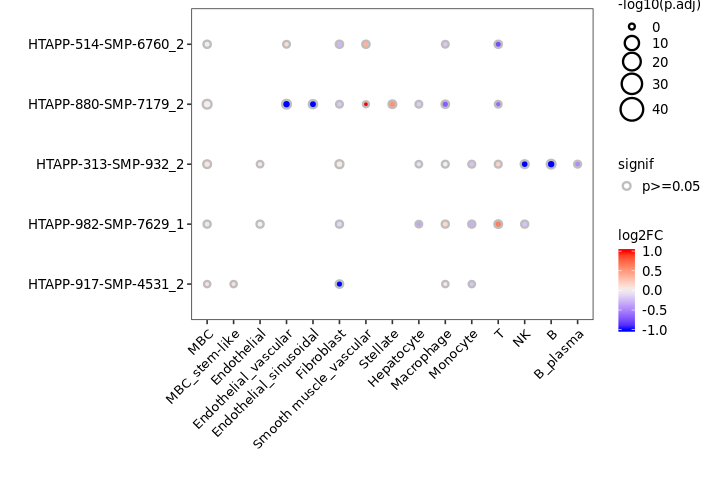

In [50]:
options(repr.plot.width = 6, repr.plot.height =4)
exseq_bin_pl[2]

In [51]:
codex_pl=get_ct_emt_association("codex_mal_obs.tsv","codex_obs.tsv",mode="codex")

[1] -0.8726946


In [52]:
all_stats=rbindlist(list(all_stats,codex_pl[[3]]))

[[1]]


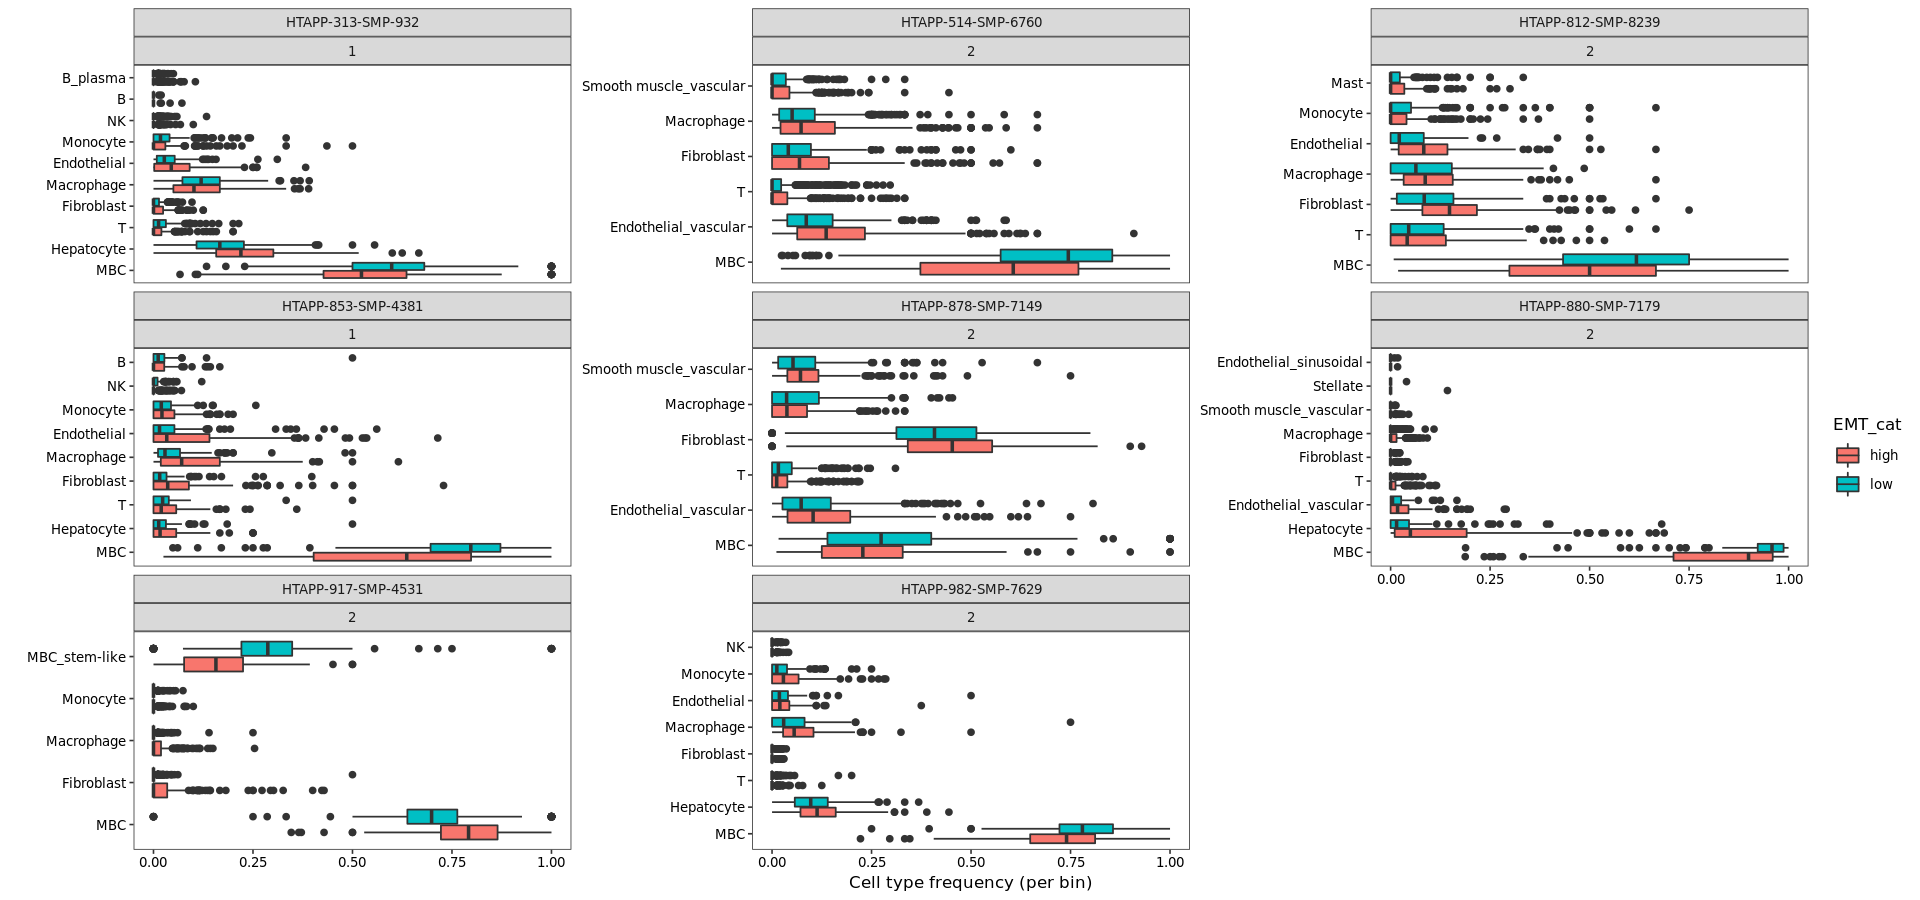

In [53]:
options(repr.plot.width = 16, repr.plot.height =7.5)
codex_pl[1]

[[1]]


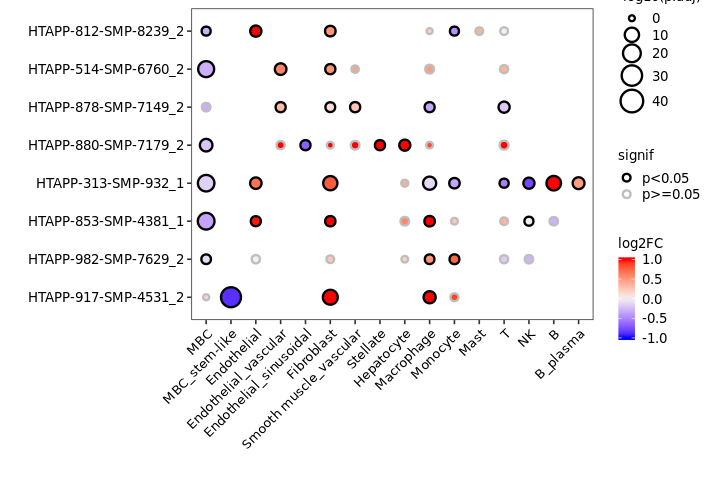

In [54]:
options(repr.plot.width = 6, repr.plot.height =4)
codex_pl[2]

### Analyse combined stats

In [55]:
all_stats[method=="merfish_clean",method:="merfish_man"]

In [56]:
all_stats_wide_lfc=dcast(all_stats,sample_repl+cell_type~method, value.var = "log2FC")
all_stats_wide_p=dcast(all_stats,sample_repl+cell_type~method, value.var = "signif")

In [57]:
cors=cor(all_stats_wide_lfc[,-c("sample_repl","cell_type")],use ="pairwise.complete.obs",method = "spearman")

In [59]:
paletteLength = 300
colors = colorRampPalette(c("blue", "white", "red"))(paletteLength)
breaks = c(seq(min(cors), 0, length.out=ceiling(paletteLength/2) + 1), 
              seq(max(cors)/paletteLength, max(cors), length.out=floor(paletteLength/2)))

png 
  2

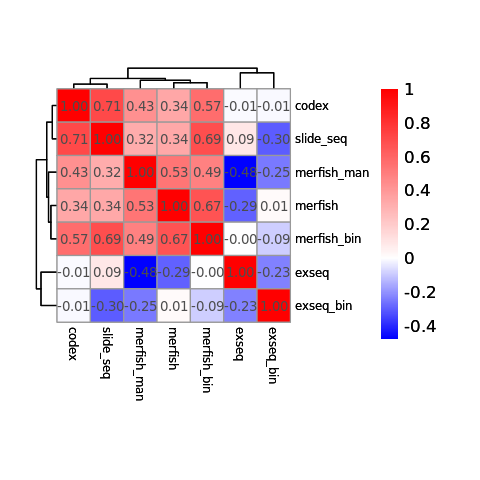

In [60]:
options(repr.plot.width =4, repr.plot.height =4)
pl=pheatmap(cors,cellwidth = 20,cellheight = 20,display_numbers = T,treeheight_row = 8,treeheight_col = 8,breaks = breaks,
         color = colors,fontsize_row=7,fontsize_col=7)
pdf("EMT_ct_fractions_cor_hm.pdf",height=3,width=4)
pl
dev.off()
pl

png 
  2

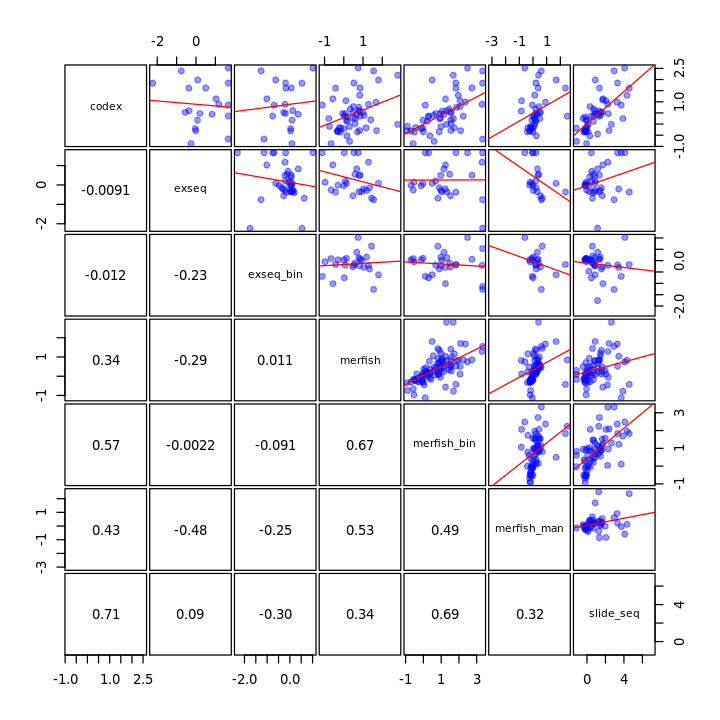

In [59]:
reg <- function(x, y, ...) {
  points(x,y, ...)
#  smoothScatter(x,y,add=T,nrpoints = 0,nbin=65,bandwidth=0.1)  
  abline(lm(y~x),col="red")  
  }# made to draw regression line instead of lowess line

panel.cor <- function(x, y, digits = 2, prefix = "", cex.cor, ...)
{
  usr <- par("usr"); on.exit(par(usr))
  par(usr = c(0, 1, 0, 1))
  r <- cor(x, y,use ="pairwise.complete.obs",method = "spearman")
  txt <- format(c(r, 0.123456789), digits = digits)[1]
  txt <- paste0(prefix, txt)
  text(0.5, 0.5, txt, cex = 1, font = 1)
}

options(repr.plot.width=6, repr.plot.height=6)
pl=function(){pairs(all_stats_wide_lfc[,-c("sample_repl","cell_type")], upper.panel = reg,
      cex = 1, pch = 19,cex.labels=0.8 ,col = adjustcolor(4, .4),gap=0.2, lower.panel = panel.cor)}

pdf("EMT_ct_fractions_pairPlot.pdf",height=6,width=6)
pl()
dev.off()
pl()

In [384]:
ct_colors['B_regulatory']="#E0115F"

In [60]:
DTlong <- melt(all_stats_wide_lfc, id.vars = c("sample_repl", "cell_type"), variable.factor = FALSE)
all_stats_long_lfc <- DTlong[DTlong, on = .(sample_repl, cell_type), allow.cartesian = TRUE
  ][variable < i.variable,
  ][, .(ID.new = paste(variable, i.variable, sep = " - "),
        sample_repl, cell_type,method.left=variable,method.right=i.variable ,lfc.left = value, lfc.right = i.value)]
head(all_stats_long_lfc)

ID.new,sample_repl,cell_type,method.left,method.right,lfc.left,lfc.right
<chr>,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>
codex - exseq,HTAPP-944-SMP-7479_3,MBC,codex,exseq,NA,NA
codex - exseq,HTAPP-944-SMP-7479_3,MBC_neuronal,codex,exseq,NA,NA
codex - exseq,HTAPP-944-SMP-7479_3,Endothelial,codex,exseq,NA,NA
codex - exseq,HTAPP-944-SMP-7479_3,Endothelial_angiogenic,codex,exseq,NA,NA
codex - exseq,HTAPP-944-SMP-7479_3,Endothelial_vascular,codex,exseq,NA,NA
codex - exseq,HTAPP-944-SMP-7479_3,Fibroblast,codex,exseq,NA,NA


In [61]:
DTlong <- melt(all_stats_wide_p, id.vars = c("sample_repl", "cell_type"), variable.factor = FALSE)
all_stats_long_p <- DTlong[DTlong, on = .(sample_repl, cell_type), allow.cartesian = TRUE
  ][variable < i.variable,
  ][, .(ID.new = paste(variable, i.variable, sep = " - "),
        sample_repl, cell_type,method.left=variable,method.right=i.variable , p.left = value, p.right = i.value)]
head(all_stats_long_p)

ID.new,sample_repl,cell_type,method.left,method.right,p.left,p.right
<chr>,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>
codex - exseq,HTAPP-944-SMP-7479_3,MBC,codex,exseq,NA,NA
codex - exseq,HTAPP-944-SMP-7479_3,MBC_neuronal,codex,exseq,NA,NA
codex - exseq,HTAPP-944-SMP-7479_3,Endothelial,codex,exseq,NA,NA
codex - exseq,HTAPP-944-SMP-7479_3,Endothelial_angiogenic,codex,exseq,NA,NA
codex - exseq,HTAPP-944-SMP-7479_3,Endothelial_vascular,codex,exseq,NA,NA
codex - exseq,HTAPP-944-SMP-7479_3,Fibroblast,codex,exseq,NA,NA


In [62]:
cors_long=as.data.table(reshape2::melt(cors))
cors_long[,ID.new:=paste0(Var1," - ",Var2),]
head(cors_long)

Var1,Var2,value,ID.new
<fct>,<fct>,<dbl>,<chr>
codex,codex,1.00000000,codex - codex
exseq,codex,-0.00909117,exseq - codex
exseq_bin,codex,-0.01203008,exseq_bin - codex
merfish,codex,0.33828820,merfish - codex
merfish_bin,codex,0.56697041,merfish_bin - codex
merfish_man,codex,0.42860269,merfish_man - codex


In [63]:
all_stats_long_comb=merge(all_stats_long_lfc,all_stats_long_p,by = c("ID.new","sample_repl","cell_type","method.left","method.right"))
all_stats_long_comb[,p.comp:=ifelse(p.left==p.right,p.left,"diverging"),]
head(all_stats_long_comb)

ID.new,sample_repl,cell_type,method.left,method.right,lfc.left,lfc.right,p.left,p.right,p.comp
<chr>,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
codex - exseq,HTAPP-944-SMP-7479_3,MBC,codex,exseq,NA,NA,NA,NA,NA
codex - exseq,HTAPP-944-SMP-7479_3,MBC_neuronal,codex,exseq,NA,NA,NA,NA,NA
codex - exseq,HTAPP-944-SMP-7479_3,Endothelial,codex,exseq,NA,NA,NA,NA,NA
codex - exseq,HTAPP-944-SMP-7479_3,Endothelial_angiogenic,codex,exseq,NA,NA,NA,NA,NA
codex - exseq,HTAPP-944-SMP-7479_3,Endothelial_vascular,codex,exseq,NA,NA,NA,NA,NA
codex - exseq,HTAPP-944-SMP-7479_3,Fibroblast,codex,exseq,NA,NA,NA,NA,NA


png 
  2

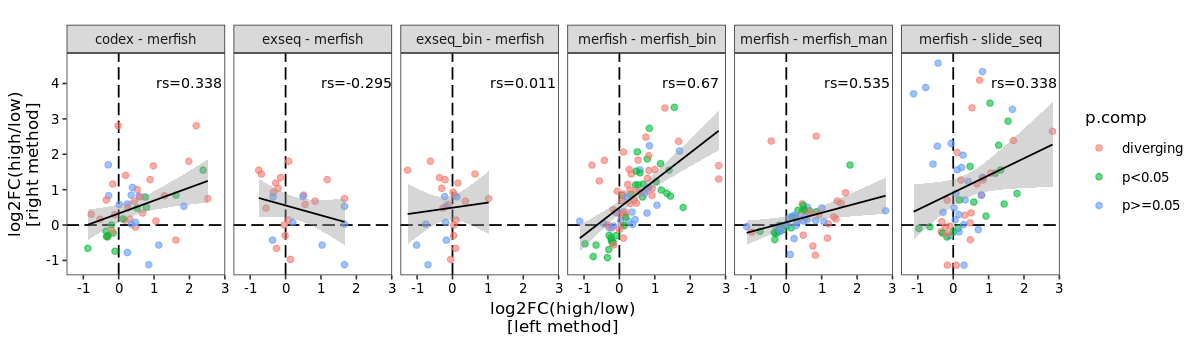

In [65]:
options(repr.plot.width =10, repr.plot.height =3)
sub_lfc=all_stats_long_comb[((method.left=="merfish")|(method.right=="merfish"))&(!is.na(lfc.left)&!is.na(lfc.right))]
sub_cors=cors_long[ID.new%in%sub_lfc$ID.new]
pl=ggplot(sub_lfc,aes(x=lfc.left,y=lfc.right))+geom_hline(yintercept = 0,lty=11)+
geom_vline(xintercept = 0,lty=11)+geom_point(aes(color=p.comp),alpha=0.6)+geom_smooth(method = 'lm',col="black",lwd=0.5)+
geom_text(data = sub_cors,x=2,y=4,aes(label=paste0("rs=",round(value,3))),size=3)+
coord_fixed(1)+facet_wrap(~ID.new,nrow=1)+xlab("log2FC(high/low)\n[left method]")+ylab("log2FC(high/low)\n[right method]")

pdf("EMT_ct_fractions_VSmerfish.pdf",height=3,width=10)
pl
dev.off()
pl